In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, KBinsDiscretizer

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from collections import Counter


from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

np.random.seed(0)
import matplotlib.pyplot as plt

import seaborn as sns; sns.set_theme()

In [2]:
def display_summary(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    precision = tp/(tp+fp)
    sensitivity = tp/(tp+fn)
    balanced_accuracy = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
    Fscore = 2.*(precision*sensitivity)/(precision+sensitivity)
    print('Matriz de confusión')
    print(np.array([[tp,fp],[fn,tn]]))
    print('Sensitividad %f',1.*tp/(tp+fn))
    print('Especificidad is %f',1.*tn/(tn+fp))
    print('Precisión %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('Precisión balanceada %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('F-score %', Fscore)
    return Fscore, balanced_accuracy

## Tabla de Contenidos

* [Análsis del dataset](#Analysis)
* [Implementación del modelo](#Model)
    * [Aproach 1](#model1)
    * [Aproach 2](#model2)
    * [Aproach 3](#model3)
    * [Aproach 4](#model4)
* [Resultados](#results)
* [Referencias](#references)

<a id = 'Analysis'></a>
# <font color = "darkblue">Análsis del dataset</font>

En esta sección del notebook se busca entender la información que se encuentra en el dataset; cómo está consituido, que variables contiene, que variables son categoricas y cuáles son númericas, etc. Para se ello se realizan las siguientes procedimientos:
- Análisis estadisticos
- Distribuciones de variables continúas
- Correlaciones de variables
- Características de trasaccciones fradulentas y características de personas que comenten fraude


Como primer paso se carga el dataset y se analiza las variables que contiene:

In [3]:
df = pd.read_csv('ds_challenge_2021.csv')
df['dispositivo']=df['dispositivo'].apply(lambda x:eval(x))
df = pd.concat([df, pd.json_normalize(df["dispositivo"])], axis=1)
df.drop(['dispositivo'], axis=1, inplace = True)
df

,ID_USER,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,model,device_score,os
0,0,F,608.345634,2020-01-21,20,Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False,2020,3,ANDROID
1,0,F,88.719243,2020-01-15,7,NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False,2020,1,ANDROID
2,1,F,790.037653,2020-01-17,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,2020,1,.
3,1,F,767.005387,2020-01-05,11,MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False,2020,3,WEB
4,1,F,254.171053,2020-01-30,10,NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False,2020,3,%%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26970,3999,M,746.192089,2020-01-08,13,NaN,Toluca,Física,40000,56,Aceptada,False,0.000000,7.461921,False,2020,2,ANDROID
26971,3999,M,941.804966,2020-01-14,15,NaN,Toluca,Física,40000,56,Aceptada,False,0.000000,9.418050,False,2020,2,WEB
26972,3999,M,251.189885,2020-01-16,11,NaN,Toluca,Virtual,40000,56,Aceptada,False,0.000000,5.023798,False,2020,2,WEB
26973,3999,M,24.182665,2020-01-13,17,NaN,Toluca,Física,40000,56,Aceptada,False,2.418266,0.217644,False,2020,5,.


In [4]:
df.dtypes

ID_USER              int64
genero              object
monto              float64
fecha               object
hora                 int64
establecimiento     object
ciudad              object
tipo_tc             object
linea_tc             int64
interes_tc           int64
status_txn          object
is_prime              bool
dcto               float64
cashback           float64
fraude                bool
model                int64
device_score         int64
os                  object
dtype: object

Como el objetivo de esta prueba es poder detectar las transacciones fraudulentas, es importante entender cual va a ser la variable y a clasificar, para ello miramos cuanto esto es su proporción sobre el total;

In [5]:
df_fraude = pd.DataFrame(df[df['fraude']==True],columns = df.columns) #Dataframe de trasancciones que son fraudulentas
df_noFraude = pd.DataFrame(df[df['fraude']==False],columns = df.columns) #Dataframe de trasancciones que no son fraudulentas
prop = len(df_fraude)/(len(df_noFraude)+len(df_fraude))*100 #Es un buen indicador para saber si los datos están balanceados
print("Porcentaje de transacciones fraudulentas del total: %.3f" % prop + "%")


Porcentaje de transacciones fraudulentas del total: 3.003%


In [6]:
df[df.columns[1:]].describe()

,monto,hora,linea_tc,interes_tc,dcto,cashback,model,device_score
count,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.0,26975.000000
mean,499.069493,11.987618,62476.811863,48.224875,17.466134,6.261186,2020.0,3.002595
std,289.309518,6.642565,21886.892902,9.587256,34.334566,4.458440,0.0,1.417432
min,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138,2020.0,1.000000
25%,246.521227,6.000000,44000.000000,40.000000,0.000000,2.791740,2020.0,2.000000
50%,500.501022,12.000000,62000.000000,48.000000,0.000000,5.636711,2020.0,3.000000
75%,749.598192,18.000000,82000.000000,57.000000,18.770710,8.531604,2020.0,4.000000
max,999.917764,23.000000,99000.000000,64.000000,199.356251,19.991582,2020.0,5.000000


<AxesSubplot:>

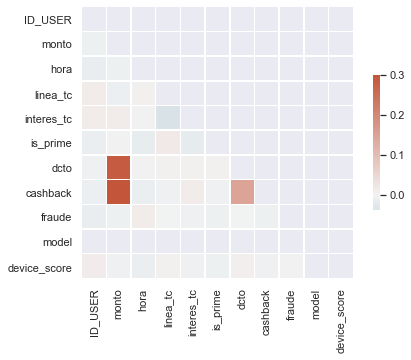

In [7]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### <font color = "darkblue">Variables númericas</font>

<AxesSubplot:xlabel='hora', ylabel='Density'>

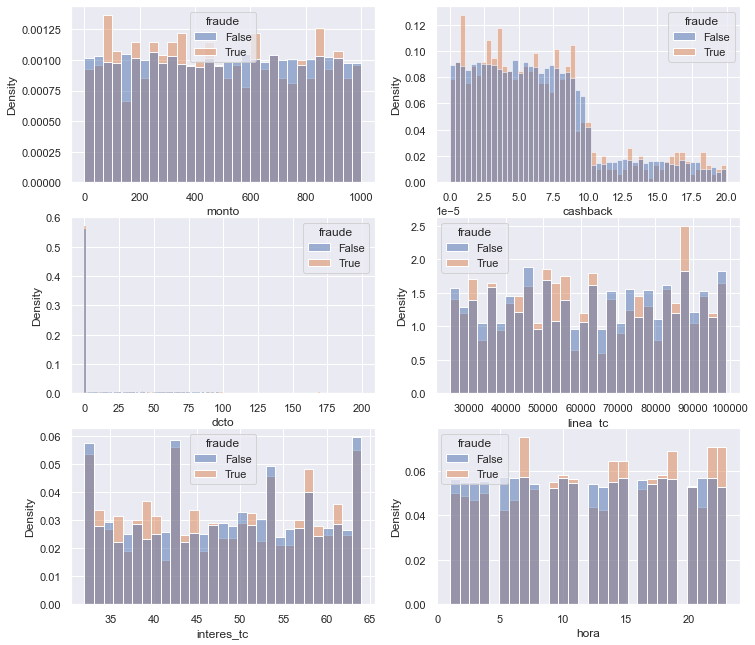

In [8]:
f, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,11))

sns.histplot(data=df, x="monto", hue="fraude", stat="density", common_norm=False, ax = axes[0][0])
sns.histplot(data=df, x="cashback", hue="fraude", stat="density", common_norm=False, ax = axes[0][1])
sns.histplot(data=df, x="dcto", hue="fraude", stat="density", common_norm=False, ax = axes[1][0])
sns.histplot(data=df, x="linea_tc", hue="fraude", stat="density", common_norm=False, ax = axes[1][1])
sns.histplot(data=df, x="interes_tc", hue="fraude", stat="density", common_norm=False, ax = axes[2][0])
sns.histplot(data=df, x="hora", hue="fraude", stat="density", common_norm=False, ax = axes[2][1])

### <font color = "darkblue">Variables categóricas</font>

<AxesSubplot:xlabel='device_score', ylabel='proportion'>

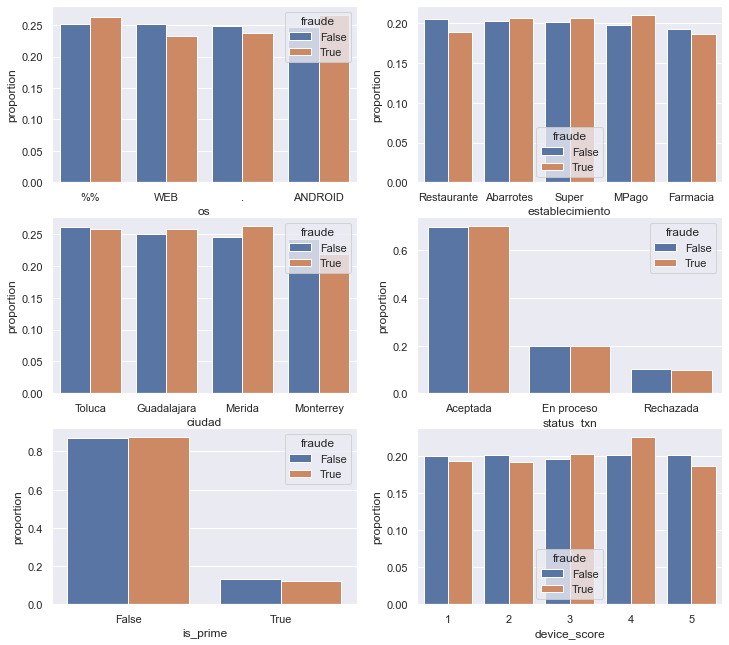

In [9]:
f, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,11))

(df["os"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="os", y="proportion", hue="fraude",ax = axes[0,0]))
(df["establecimiento"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="establecimiento", y="proportion", hue="fraude",ax = axes[0,1]))
(df["ciudad"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="ciudad", y="proportion", hue="fraude",ax = axes[1,0]))
(df["status_txn"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="status_txn", y="proportion", hue="fraude",ax = axes[1,1]))
(df["is_prime"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="is_prime", y="proportion", hue="fraude",ax = axes[2,0]))
(df["device_score"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="device_score", y="proportion", hue="fraude",ax = axes[2,1]))

## Análisis a nivel de transacción
Como se observó anteriormente, el dataset presenta cada dato a nivel de transacción, en donde hay usuarios con más de una trasancción, debido a esto es importante entender como se comporta las transacciones de nivel de sus variables y posteriormente hacer el mismo análisis a nivel de usuario. Para ello se procede a entender como se comportan las variables

In [10]:
#Variables numericas
df_fraude_grouped = df_fraude.groupby(['ID_USER']).agg({'monto':'mean','cashback':'mean',
                                                       'linea_tc':'mean','interes_tc':'mean',
                                                       'dcto':'mean'})
df_noFraude_grouped = df_noFraude.groupby(['ID_USER']).agg({'monto':'mean','cashback':'mean',
                                                           'linea_tc':'mean','interes_tc':'mean',
                                                            'dcto':'mean'})


mean_amount_fraud = np.mean(df_fraude_grouped['monto'])
mean_amount_nofraud =np.mean(df_noFraude_grouped['monto'])
print("Monto")
print("Promedio de monto en trasacciones fraudulentas: %.3f" % mean_amount_nofraud)
print("Promedio de monto en trasacciones no fraudulentas: %.3f" % mean_amount_fraud)

print("Cashback")
mean_cashback_fraud = np.mean(df_fraude_grouped['cashback'])
mean_cashback_nofraud =np.mean(df_noFraude_grouped['cashback'])
print("Promedio de cashback en trasacciones fraudulentas: %.3f" % mean_cashback_fraud)
print("Promedio de cashback en trasacciones no fraudulentas: %.3f" % mean_cashback_nofraud)

print("Línea TC")
mean_lineaTC_fraud = np.mean(df_fraude_grouped['linea_tc'])
mean_lineaTC_nofraud =np.mean(df_noFraude_grouped['linea_tc'])
print("Promedio de linea_tc en trasacciones fraudulentas: %.3f" % mean_lineaTC_fraud)
print("Promedio de linea_tc en trasacciones no fraudulentas: %.3f" % mean_lineaTC_nofraud)

print("Interés TC")
mean_interes_tc_fraud = np.mean(df_fraude_grouped['interes_tc'])
mean_interes_tc_nofraud =np.mean(df_noFraude_grouped['interes_tc'])
print("Promedio de interes_tc en trasacciones fraudulentas: %.3f" % mean_interes_tc_fraud)
print("Promedio de interes_tc en trasacciones no fraudulentas: %.3f" % mean_interes_tc_nofraud)

Monto
Promedio de monto en trasacciones fraudulentas: 496.196
Promedio de monto en trasacciones no fraudulentas: 493.438
Cashback
Promedio de cashback en trasacciones fraudulentas: 6.154
Promedio de cashback en trasacciones no fraudulentas: 6.222
Línea TC
Promedio de linea_tc en trasacciones fraudulentas: 61448.889
Promedio de linea_tc en trasacciones no fraudulentas: 62339.106
Interés TC
Promedio de interes_tc en trasacciones fraudulentas: 48.156
Promedio de interes_tc en trasacciones no fraudulentas: 48.158


## Analisis a nivel de usuario
Ahora se procede a revisar esta información a nivel de usuario, ya que es importante entender sí existe alguna característica evidente de las personas que tienen alguna transacción fraudulenta. Dentro del dataset, existen bastantes usuarios que tienen muchas transacción correctas y algunas fraudulentas, dado esto se define como usuario fraudulente aquel tenga al menos una transacción fraudulenta.

In [11]:
ids_fraude = df[df['fraude']==True][['ID_USER']].drop_duplicates()
ids_fraude['user_fraude'] = 1
ids_fraude.set_index('ID_USER',inplace=True)
df_p = df.set_index('ID_USER').join(ids_fraude)

df_fraude_grouped = df_p[df_p['user_fraude']==1].groupby(['ID_USER']).agg({'fecha':'count','monto':'mean','cashback':'mean',
                                                       'linea_tc':'mean','interes_tc':'mean',
                                                       'dcto':'mean'})
df_noFraude_grouped = df_p[df_p['user_fraude']!=1].groupby(['ID_USER']).agg({'fecha':'count','monto':'mean','cashback':'mean',
                                                       'linea_tc':'mean','interes_tc':'mean',
                                                       'dcto':'mean'})
print("Transacciones")
mean_trans_fraud = np.mean(df_fraude_grouped['fecha'])
mean_trans_nofraud =np.mean(df_noFraude_grouped['fecha'])
print("Promedio de transacciones personas que no hacen fraude: %.3f" % mean_trans_nofraud)
print("Promedio de transacciones personas que sí hacen fraude: %.3f" % mean_trans_fraud)

print("Monto")
mean_amount_fraud = np.mean(df_fraude_grouped['monto'])
mean_amount_nofraud =np.mean(df_noFraude_grouped['monto'])
print("Promedio de gasto promedio personas que no hacen fraude: %.3f" % mean_amount_nofraud)
print("Promedio de gasto promedio personas que sí hacen fraude: %.3f" % mean_amount_fraud)

print("Cashback")
mean_cashback_fraud = np.mean(df_fraude_grouped['cashback'])
mean_cashback_nofraud =np.mean(df_noFraude_grouped['cashback'])
print("Promedio de cashback personas que no hacen fraude: %.3f" % mean_cashback_fraud)
print("Promedio de cashback promedio personas que sí hacen fraude: %.3f" % mean_cashback_nofraud)


Transacciones
Promedio de transacciones personas que no hacen fraude: 5.769
Promedio de transacciones personas que sí hacen fraude: 11.544
Monto
Promedio de gasto promedio personas que no hacen fraude: 495.662
Promedio de gasto promedio personas que sí hacen fraude: 497.543
Cashback
Promedio de cashback personas que no hacen fraude: 6.231
Promedio de cashback promedio personas que sí hacen fraude: 6.203


Como se observa en los resultados anteriores, una diferencia notable entre estos dos grupos es que la cantidad de trasacciones promedio es mayor para las personas que cometen fraude, tenemos como ejemplo el siguiente caso:

In [12]:
df[df['ID_USER']==9][['ID_USER','fecha','fraude','monto']].sort_values(['fecha'])

,ID_USER,fecha,fraude,monto
36,9,2020-01-04,False,305.178078
41,9,2020-01-07,False,449.202371
43,9,2020-01-07,False,9.490080
37,9,2020-01-14,True,253.327147
38,9,2020-01-16,False,18.471148
39,9,2020-01-17,False,637.948552
42,9,2020-01-18,False,586.507627
35,9,2020-01-21,False,687.625262
44,9,2020-01-26,False,581.564202
40,9,2020-01-27,False,812.327552


Este usuario, posee 10 trasacciones en donde 1 de ella fue categorizada como fraudulenta, lo curioso es que el usuario sigue generando muchas más transacciones despues.

<AxesSubplot:xlabel='genero', ylabel='proportion'>

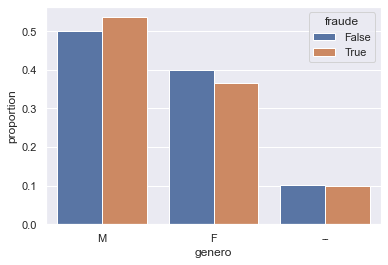

In [13]:
x, y, hue = "genero", "proportion", "fraude"
hue_order = df_p['user_fraude'].unique()

(df_p[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

<a id = 'Model'></a>
# <font color = "darkblue">Modelo</font>

Dado lo observado en la sección anterior, este apartado tiene como objetivo probar diferentes modelos para la detección de fraude. Para ello se utilizará como modelo base los árboles de decisión que han demostrado ser buenos para modelos desbalanceados y para detección de fraude.[1]

Para encontrar el mejor modelo se prueba diferentes métodos, se toman los resultados y se analiza que modelo fue el que tuvo el mejor rendimiendo. Los métodos utilizados fueron los siguientes:
* Árbol de decisión
* Árbol de decisión con sobre muestreo
* Árbol de decisión SMOTE
* Árbol de decisión con costos asociados de clasificación

Adicionalmente, por cada modelo se generan subsets de entrenamiento y test, utilizando la proporción 0.75 y 0.25 respectivamente. Por otro lado, se utilizan como métricas de medición matriz de confución, F-score y sensibilidad.

<a id = 'model1'></a>
## <font color = "darkblue">1er aproach (Árbol de decisión)</font>


Para este primer modelo se quiso probar que resultados se obtienen con la data original, para ello se separan las variables numericas de las categoricas y se obtienen los resultados del modelo. Posteriormente, se utilizan árboles de decisión para detectar que variables son las más representativas para la clasificación, luego se retiran y se vuelve a probar el modelo

In [14]:
df_clasificar11 = pd.DataFrame(df, columns=df.columns)
col_names11 = df.columns
feature_cols11 = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback','device_score', 'os']

X11 = df_clasificar11[feature_cols11]
y11 = df_clasificar11['fraude']
X_train11, X_test11, y_train11, y_test11 = train_test_split(X11,
                                                    y11,
                                                    test_size=0.25)



In [15]:
# Parte númerica
numeric_features11 = ['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback']
numeric_transformer11 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features11 = ['genero', 'fecha', 'establecimiento', 'ciudad','tipo_tc','status_txn','is_prime', 'os','device_score']
categorical_transformer11 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor11 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer11, numeric_features11),
        ('cat', categorical_transformer11, categorical_features11)])


In [16]:
# Árbol de decisón
clf11 = Pipeline(steps=[('preprocessor', preprocessor11),
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf11 = clf11.fit(X_train11, y_train11)
y_pred_tree11 = clf11.predict(X_test11)
print('Decision Tree')
F_score_11, acc_11 = display_summary(y_test11,y_pred_tree11)


Decision Tree
Matriz de confusión
[[   1  289]
 [ 212 6242]]
Sensitividad %f 0.004694835680751174
Especificidad is %f 0.9557495023732966
Precisión %f 0.925711743772242
Precisión balanceada % 0.48022216902702386
F-score % 0.003976143141153081


#### Selección de Variables

In [17]:
df_prep12 = pd.DataFrame(preprocessor11.fit_transform(X_train11[feature_cols11]), 
                       columns=['monto', 'hora', 'linea_tc','interes_tc','dcto',
                                'cashback','device_score','genero', 'fecha', 
                                'establecimiento', 'ciudad','tipo_tc','status_txn',
                                'is_prime', 'os'])
#Se crea un modelo de arbol que se utilizará para hallar las variables
reg11 = ExtraTreesClassifier(n_estimators=50) 
reg11.fit(df_prep12, y_train11) #Entrenamiento

imp12 = reg11.feature_importances_ #Se guardan las importancias de cada variable al modelo
mean12 = np.mean(imp12)
bool_array12 = imp12 >= mean12 #Vector booleano para saber que importancias están por encima de la media
indices12 = [] #Vector de indicación de variables importantes
indices2_12 = [] #Vector de indicación de variables no importantes
H = 0 
H2 = 0

# Ciclo que busca las variables más representativas y almacena sus indices 
for q in range(len(bool_array12)):
    if ~bool_array12[q]:
        indices12.append(H)
    H = H+1 
# Ciclo que busca las variables menos representativas y almacena sus indices 
for w in range(len(bool_array12)):
    if bool_array12[w]:
        indices2_12.append(H2)
    H2 = H2+1

columnas_eliminar12 = [] # Vector que almacena el nombre de las variables menos representativas
columnas_restantes12 = [] # Vector que almacena el nombre de las variables más representativas
for ind in indices12:
    columnas_eliminar12.append(df_prep12.columns[ind])
for ind in indices2_12:
    columnas_restantes12.append(df_prep12.columns[ind])
    
print('columnas a eliminar:', columnas_eliminar12)
print('columnas que se mantienen:',columnas_restantes12)

columnas a eliminar: ['dcto', 'device_score', 'establecimiento', 'ciudad', 'tipo_tc', 'status_txn', 'is_prime', 'os']
columnas que se mantienen: ['monto', 'hora', 'linea_tc', 'interes_tc', 'cashback', 'genero', 'fecha']


In [18]:
df_clasificar12 = pd.DataFrame(df, columns=df.columns)
feature_cols12 = [ 'monto', 'hora',   'linea_tc', 'interes_tc',
                'cashback','fecha']

X12 = df_clasificar12[feature_cols12]
y12 = df_clasificar12['fraude']
X_train12, X_test12, y_train12, y_test12 = train_test_split(X12,
                                                    y12,
                                                    test_size=0.25)

In [19]:
# Parte númerica
numeric_features12 = ['monto', 'hora', 'linea_tc','interes_tc','cashback']
numeric_transformer12 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features12 = [ 'fecha']
categorical_transformer12 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor12 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer12, numeric_features12),
        ('cat', categorical_transformer12, categorical_features12)])

# Árbol de decisón
clf12 = Pipeline(steps=[('preprocessor', preprocessor12),
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf12 = clf12.fit(X_train12, y_train12)
y_pred_tree12 = clf12.predict(X_test12)
F_score_12, acc_12 = display_summary(y_test12,y_pred_tree12)



Matriz de confusión
[[  10  273]
 [ 198 6263]]
Sensitividad %f 0.04807692307692308
Especificidad is %f 0.9582313341493268
Precisión %f 0.9301601423487544
Precisión balanceada % 0.5031541286131249
F-score % 0.04073319755600815


<a id = 'model2'></a>
# <font color = "darkblue">2do aproach (Sobre muestreo + Sub muestreo)</font>


Para el segundo modelo se quiso arreglar el desbalance que existe en las categorías a clasificar, para ello se utilizó la librería de SciKit Learn Sample, y se sobre muestro la clase minoritaria con reemplazo y se sub muestro la clase mayoritaria sin reemplazo.  

In [20]:
df_clasificar21 = pd.DataFrame(resample(df[df['fraude']==True], n_samples=3000, replace = True),columns = df.columns)

df_clasificar21 = df_clasificar21.append(pd.DataFrame(resample(df[df['fraude']==False], n_samples=5000, replace = False)))
print('Tamaño dataset sampleado %s' % Counter(df_clasificar21['fraude']))

Tamaño dataset sampleado Counter({False: 5000, True: 3000})


In [21]:

feature_cols21 = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback','device_score', 'os']

X21 = df_clasificar21[feature_cols21]
y21 = df_clasificar21['fraude']
X_train21, X_test21, y_train21, y_test21 = train_test_split(X21,
                                                    y21,
                                                    test_size=0.25)

In [22]:
# Parte númerica
numeric_features21 = ['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback']
numeric_transformer21 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features21 = ['genero', 'fecha', 'establecimiento', 'ciudad','tipo_tc','status_txn','is_prime', 'os','device_score']
categorical_transformer21 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor21 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer21, numeric_features21),
        ('cat', categorical_transformer21, categorical_features21)])

# Árbol de decisón
clf21 = Pipeline(steps=[('preprocessor', preprocessor21),
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf21 = clf21.fit(X_train21, y_train21)
y_pred_tree21 = clf21.predict(X_test21)
print('Decision Tree')
F_score_21, acc_21 = display_summary(y_test21,y_pred_tree21)


Decision Tree
Matriz de confusión
[[ 721  198]
 [  38 1043]]
Sensitividad %f 0.9499341238471674
Especificidad is %f 0.8404512489927478
Precisión %f 0.882
Precisión balanceada % 0.8951926864199575
F-score % 0.8593563766388558


#### Selección de Variables

In [23]:
df_prep22 = pd.DataFrame(preprocessor21.fit_transform(X_train21[feature_cols21]), 
                       columns=['monto', 'hora', 'linea_tc','interes_tc',
                                'dcto','cashback','device_score','genero', 
                                'fecha', 'establecimiento', 'ciudad','tipo_tc',
                                'status_txn','is_prime', 'os'])
#Se crea un modelo de arbol que se utilizará para hallar las variables
reg22 = ExtraTreesClassifier(n_estimators=50) 
reg22.fit(df_prep22, y_train21) #Entrenamiento

imp22 = reg22.feature_importances_ #Se guardan las importancias de cada variable al modelo
mean22 = np.mean(imp22)
bool_array22 = imp22 >= mean22 #Vector booleano para saber que importancias están por encima de la media
indices22 = [] #Vector de indicación de variables importantes
indices2_22 = [] #Vector de indicación de variables no importantes
H = 0 
H2 = 0

# Ciclo que busca las variables más representativas y almacena sus indices 
for q in range(len(bool_array22)):
    if ~bool_array22[q]:
        indices22.append(H)
    H = H+1 
# Ciclo que busca las variables menos representativas y almacena sus indices 
for w in range(len(bool_array22)):
    if bool_array22[w]:
        indices2_22.append(H2)
    H2 = H2+1

columnas_eliminar22 = [] # Vector que almacena el nombre de las variables menos representativas
columnas_restantes22 = [] # Vector que almacena el nombre de las variables más representativas
for ind in indices22:
    columnas_eliminar22.append(df_prep22.columns[ind])
for ind in indices2_22:
    columnas_restantes22.append(df_prep22.columns[ind])
    
    
print('columnas a eliminar:', columnas_eliminar22)
print('columnas que se mantienen:',columnas_restantes22)

columnas a eliminar: ['dcto', 'device_score', 'ciudad', 'tipo_tc', 'status_txn']
columnas que se mantienen: ['monto', 'hora', 'linea_tc', 'interes_tc', 'cashback', 'genero', 'fecha', 'establecimiento', 'is_prime', 'os']


In [24]:
df_clasificar22 = pd.DataFrame(resample(df[df['fraude']==True], n_samples=3000, replace = True),columns = df.columns)

df_clasificar22 = df_clasificar22.append(pd.DataFrame(resample(df[df['fraude']==False], n_samples=5000, replace = False)))
feature_cols22 = ['monto', 'fecha', 'hora', 'linea_tc', 'interes_tc',
                'cashback','genero',  'os']

X22 = df_clasificar22[feature_cols22]
y22 = df_clasificar22['fraude']
X_train22, X_test22, y_train22, y_test22 = train_test_split(X22,
                                                    y22,
                                                    test_size=0.25)

In [25]:
# Parte númerica
numeric_features22 = ['monto', 'hora', 'linea_tc','interes_tc','cashback']
numeric_transformer22 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features22 = [ 'fecha', 'genero','os']
categorical_transformer22 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor22 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer22, numeric_features22),
        ('cat', categorical_transformer22, categorical_features22)])

# Árbol de decisón
clf22 = Pipeline(steps=[('preprocessor', preprocessor22),
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf22 = clf22.fit(X_train22, y_train22)
y_pred_tree22 = clf22.predict(X_test22)
print('Decision Tree')
F_score_22, acc_22 = display_summary(y_test22,y_pred_tree22)

Decision Tree
Matriz de confusión
[[ 714  221]
 [  51 1014]]
Sensitividad %f 0.9333333333333333
Especificidad is %f 0.8210526315789474
Precisión %f 0.864
Precisión balanceada % 0.8771929824561404
F-score % 0.84



<a id = 'model3'></a>
# <font color = "darkblue"> 3er aproach (SMOTE)</font>

Para este ejercicio, se quiso probar una forma distinta de muestreo de la clase minoritaria, la técnica SMOTE es muy útil cuando la clase minoritaria es considerablemente menor [2]

In [26]:
# Parte númerica
numeric_features31 = ['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback']
numeric_transformer31 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features31 = ['genero', 'fecha', 'establecimiento', 'ciudad','tipo_tc','status_txn','is_prime',
                        'model', 'os','device_score']
categorical_transformer31 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor31 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer31, numeric_features31),
        ('cat', categorical_transformer31, categorical_features31)])


feature_cols31 = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback', 'model','device_score', 'os']
df_clasificar31 = pd.DataFrame(df, columns=df.columns)
df_prep31 = pd.DataFrame(preprocessor31.fit_transform(df_clasificar31[feature_cols31]), 
                       columns=['monto', 'hora', 'linea_tc','interes_tc',
                                        'dcto','cashback','device_score','genero', 
                                        'fecha','establecimiento', 'ciudad','tipo_tc',
                                        'status_txn','is_prime','model', 'os'])

X31 = df_prep31[feature_cols31]
y31 = df['fraude']

# Apply the SMOTE over−sampling 
sm31 = SMOTE(sampling_strategy='auto' )
X_resampled31, y_resampled31 = sm31.fit_resample(X31, y31)
print('Resampled dataset shape %s' % Counter(y_resampled31))

Resampled dataset shape Counter({False: 26165, True: 26165})


In [27]:
X31 = X_resampled31
y31 = y_resampled31
X_train31, X_test31, y_train31, y_test31 = train_test_split(X31,
                                                    y31,
                                                    test_size=0.25)

# Árbol de decisón
clf31 = Pipeline(steps=[
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf31 = clf31.fit(X_train31, y_train31)
y_pred_tree31 = clf31.predict(X_test31)
print('Decision Tree')
F_score_31, acc_31 = display_summary(y_test31,y_pred_tree31)


Decision Tree
Matriz de confusión
[[6326  329]
 [ 180 6248]]
Sensitividad %f 0.9723332308638181
Especificidad is %f 0.9499771932492017
Precisión %f 0.9610945501796224
Precisión balanceada % 0.9611552120565099
F-score % 0.9613251272699643


#### Selección de Variables

In [28]:
df_prep32 = pd.DataFrame(preprocessor31.fit_transform(df_clasificar31[feature_cols31]), 
                       columns=['monto', 'hora', 'linea_tc','interes_tc',
                                        'dcto','cashback','device_score','genero', 
                                        'fecha','establecimiento', 'ciudad','tipo_tc',
                                        'status_txn','is_prime','model', 'os'])
#Se crea un modelo de arbol que se utilizará para hallar las variables
reg32 = ExtraTreesClassifier(n_estimators=50) 
reg32.fit(X_resampled31, y_resampled31) #Entrenamiento

imp32 = reg32.feature_importances_ #Se guardan las importancias de cada variable al modelo
mean32 = np.mean(imp32)
bool_array32 = imp32 >= mean32 #Vector booleano para saber que importancias están por encima de la media
indices32 = [] #Vector de indicación de variables importantes
indices2_32 = [] #Vector de indicación de variables no importantes
H = 0 
H2 = 0

# Ciclo que busca las variables más representativas y almacena sus indices 
for q in range(len(bool_array32)):
    if ~bool_array32[q]:
        indices32.append(H)
    H = H+1 
# Ciclo que busca las variables menos representativas y almacena sus indices 
for w in range(len(bool_array32)):
    if bool_array32[w]:
        indices2_32.append(H2)
    H2 = H2+1

columnas_eliminar32 = [] # Vector que almacena el nombre de las variables menos representativas
columnas_restantes32 = [] # Vector que almacena el nombre de las variables más representativas
for ind in indices32:
    columnas_eliminar32.append(df_prep32.columns[ind])
for ind in indices2_32:
    columnas_restantes32.append(df_prep32.columns[ind])
    
        
print('columnas a eliminar:', columnas_eliminar32)
print('columnas que se mantienen:',columnas_restantes32)

columnas a eliminar: ['monto', 'hora', 'interes_tc', 'genero', 'fecha', 'establecimiento', 'ciudad', 'tipo_tc', 'status_txn']
columnas que se mantienen: ['linea_tc', 'dcto', 'cashback', 'device_score', 'is_prime', 'model', 'os']


In [29]:
# Árbol de decisón
clf32 = Pipeline(steps=[
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf32 = clf32.fit(X_train31[columnas_restantes32], y_train31)
y_pred_tree32 = clf32.predict(X_test31[columnas_restantes32])
print('Decision Tree')
F_score_32, acc_32 = display_summary(y_test31,y_pred_tree31)


Decision Tree
Matriz de confusión
[[6326  329]
 [ 180 6248]]
Sensitividad %f 0.9723332308638181
Especificidad is %f 0.9499771932492017
Precisión %f 0.9610945501796224
Precisión balanceada % 0.9611552120565099
F-score % 0.9613251272699643



<a id = 'model3'></a>
# <font color = "darkblue"> 4to Aproach (Modelo sensible al costo)</font>

Con base al paper "Fraud Detection by Stacking Cost-Sensitive Decision Trees" se quiso tomar un enfoque distinto y llevar el problema a un enfoque más orientado a la realidad del problema. En este texto se describe como los modelos de fraude que tienen en cuentas los costos reales de clasificar mal o bien pueden afectar el resultado del modelo. 

In [30]:
from metrics import cost_loss, savings_score
from models import  CostSensitiveDecisionTreeClassifier 
#Librearias tomadas de COSTCLA https://albahnsen.github.io/CostSensitiveClassification/

In [31]:
df_clasificar41 = df

feature_cols41 = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback', 'model','device_score', 'os']

X41 = df_clasificar41[feature_cols41]
y41 = df_clasificar41['fraude']

X_train41, X_test41, y_train41, y_test41 = train_test_split(X41,
                                                    y41,
                                                    test_size=0.25)

# Parte númerica
numeric_features41 = ['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback']
numeric_transformer41 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features41 = ['genero', 'fecha', 'establecimiento', 'ciudad','tipo_tc','status_txn','is_prime',
                        'model', 'os','device_score']
categorical_transformer41 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor41 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer41, numeric_features41),
        ('cat', categorical_transformer41, categorical_features41)])



In [32]:

cost_mat_train41 = np.zeros((len(y_train41),4))
#Costo de falsos positivos
cost_mat_train41[:,0]=10
#Costo de falsos negativos
cost_mat_train41[:,1]=X_train41['monto']
#Costo de positivos verdaderos
cost_mat_train41[:,2]=10
 
cost_mat_test41 = np.zeros((len(y_test41),4))
cost_mat_test41[:,0]=10
cost_mat_test41[:,1]=X_test41['monto']
cost_mat_test41[:,2]=10

In [33]:

h41 = CostSensitiveDecisionTreeClassifier()
h41.fit(np.array(preprocessor41.fit_transform(X_train41[feature_cols41])), np.array(y_train41), cost_mat_train41)
y_pred_tree41 = h41.predict(np.array(preprocessor41.fit_transform(X_test41[feature_cols41])))

print('decision tree: cost sensitve learning')
print(cost_loss(y_test41,y_pred_tree41,cost_mat_test41))

print('Decision Tree')
F_score_41, acc_41 = display_summary(y_test41,y_pred_tree41)

decision tree: cost sensitve learning
60644.92371775772
Decision Tree
Matriz de confusión
[[ 142 4683]
 [  61 1858]]
Sensitividad %f 0.6995073891625616
Especificidad is %f 0.28405442592875707
Precisión %f 0.29655990510083036
Precisión balanceada % 0.49178090754565934
F-score % 0.05648369132856007



<a id = 'model3'></a>
# <font color = "darkblue"> 5to Aproach (Modelo sensible al costo+SMOTE) </font>

Con base al paper "Fraud Detection by Stacking Cost-Sensitive Decision Trees" se quiso tomar un enfoque distinto y llevar el problema a un enfoque más orientado a la realidad del problema. En este texto se describe como los modelos de fraude que tienen en cuentas los costos reales de clasificar mal o bien pueden afectar el resultado del modelo. 

In [34]:
# Parte númerica
numeric_features51 = ['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback']
numeric_transformer51 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features51 = ['genero', 'fecha', 'establecimiento', 'ciudad','tipo_tc','status_txn','is_prime',
                        'model', 'os','device_score']
categorical_transformer51 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor51 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer51, numeric_features51),
        ('cat', categorical_transformer51, categorical_features51)])


feature_cols51 = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback', 'model','device_score', 'os']
df_clasificar51 = pd.DataFrame(df, columns=df.columns)
df_prep51 = pd.DataFrame(preprocessor51.fit_transform(df_clasificar51[feature_cols51]), 
                       columns=['monto', 'hora', 'linea_tc','interes_tc',
                                        'dcto','cashback','device_score','genero', 
                                        'fecha','establecimiento', 'ciudad','tipo_tc',
                                        'status_txn','is_prime','model', 'os'])

X51 = df_prep51[feature_cols51]
y51 = df['fraude']

# Apply the SMOTE over−sampling 
sm51 = SMOTE(sampling_strategy='auto' )
X_resampled51, y_resampled51 = sm51.fit_resample(X51, y51)
print('Resampled dataset shape %s' % Counter(y_resampled51))

Resampled dataset shape Counter({False: 26165, True: 26165})


In [35]:
X51 = X_resampled51
y51 = y_resampled51
X_train51, X_test51, y_train51, y_test51 = train_test_split(X51,
                                                    y51,
                                                    test_size=0.25)
cost_mat_train51 = np.zeros((len(y_train51),4))
#Costo falsos positivos
cost_mat_train51[:,0]=100
#Costos falsos negativos
cost_mat_train51[:,1]=X_train51['monto']#monto de transacción
#Costo de verdaderos positivos
cost_mat_train51[:,2]=100
 
cost_mat_test51 = np.zeros((len(y_test51),4))
cost_mat_test51[:,0]=100
cost_mat_test51[:,1]=X_test51['monto']
cost_mat_test51[:,2]=100

h51 = CostSensitiveDecisionTreeClassifier()
h51.fit(np.array(X_train51[feature_cols51]), np.array(y_train51), cost_mat_train51)
y_pred_tree51 = h51.predict(np.array(X_test51[feature_cols51]))

print('decision tree: cost sensitve learning')
print(cost_loss(y_test51,y_pred_tree51,cost_mat_test51))

print('Decision Tree')
F_score_51, acc_51 = display_summary(y_test51,y_pred_tree51)

decision tree: cost sensitve learning
1050346.963419895
Decision Tree
Matriz de confusión
[[5445 3213]
 [1139 3286]]
Sensitividad %f 0.8270048602673147
Especificidad is %f 0.505616248653639
Precisión %f 0.6673545822823511
Precisión balanceada % 0.6663105544604768
F-score % 0.7144731662511481


<a id = 'results'></a>
# <font color = "darkblue"> Resultados y conclusiones</font>

Como se presentó al comienzo de este notebook, el objetivo de este ejercicio fue describir y encontrar el modelo que mejor detecte transacciones fraudulentas. De los resultados obtenidos, se encontró que los modelos que utilizan técnicas de muestreo fueron los que mejores resultados obtuvieron. En donde, utilizando las metricas recomendas para problemas desbalanceados, el modelo con mejor performance fue el <font color = "darkblue"> árbol de decisión con SMOTE</font> filtrando las variables más representativas, en donde obtuvo un F-Score de <font color = "darkblue"> 0.96</font> y una precisión balanceada de <font color = "darkblue"> 0.96</font>. 

Adicionalmente, y como era de esperarse, los modelos que no se muestrearon tuvieron el peor desempeño. Finalmente, el modelo que utiliza la matriz de costos, no tuvo el mejor resultado pero para no ser balanceado (y muestreado), demostró un gran performance con respecto al modelo no muestreado. Dado esto, se cree que los resultados no tuvieron el mismo performance dado que, cómo se vio en la sección 1 de este notebook, la distribución del monto de las transacciones es muy plana, lo que ocasiona que sea dificil calcular un costo asociado a los FP y TP.

In [36]:
df_resultados = pd.DataFrame(np.array([['1.1 Árbol de decisión', F_score_11, acc_11],
                                      ['1.2 Árbol de decisión (selección de variables)', F_score_12, acc_12],
                                      ['2.1 Árbol de decisión muestreado', F_score_21, acc_21],
                                      ['2.2 Árbol de decisión muestreado (selección de variables)', F_score_22, acc_22],
                                      ['3.1 Árbol de decisión SMOTE', F_score_31, acc_31],
                                      ['3.2 Árbol de decisión SMOTE (selección de variables)', F_score_32, acc_32],
                                      ['4.1 Árbol de decisión Costos', F_score_41, acc_41],
                                      ['5.1 Árbol de decisión Costos+SMOTE', F_score_51, acc_51],
                                      ]), 
                            columns= ['Modelo', 'F-Score','Balanced Acc'])
df_resultados

,Modelo,F-Score,Balanced Acc
0,1.1 Árbol de decisión,0.003976143141153081,0.48022216902702386
1,1.2 Árbol de decisión (selección de variables),0.04073319755600815,0.5031541286131249
2,2.1 Árbol de decisión muestreado,0.8593563766388558,0.8951926864199575
3,2.2 Árbol de decisión muestreado (selección de...,0.84,0.8771929824561404
4,3.1 Árbol de decisión SMOTE,0.9613251272699643,0.9611552120565099
5,3.2 Árbol de decisión SMOTE (selección de vari...,0.9613251272699643,0.9611552120565099
6,4.1 Árbol de decisión Costos,0.05648369132856007,0.49178090754565934
7,5.1 Árbol de decisión Costos+SMOTE,0.7144731662511481,0.6663105544604768



### <font color = "darkblue"> Posibles siguientes pasos</font>

Como se mencionó anteriormente, los mejores resultados se deben a los modelos en los que se utilizó alguna tecnica de muestreo, pero si quisera profundizar un futuro si se genera un cambio significativo si se utilizara  <font color = "darkblue"> transaction aggregation methodology</font>, ya que esta estrategia agrega variables transaccionales que pueden ayudar a los performances de los modelos. Adicionalmente, tambien sería bueno utilizar el método de "Apilar" árboles de decisión [1] [3]

Por otro lado, dado lo encontrado en el análisis se debe agregar variables relacionadas a la cantidad de transacciones de los usuarios, ya que se encontró que las personas fraudulentas tienen más transacciones que las que no.